In [1]:
import sys, os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
# import pickle as pk
import numpy as np
import torch
dev = torch.device("cuda")
import torch.optim as optim
# from torch.distributions import MultivariateNormal
# from torch.distributions import Normal
root_dir = '/mnt/home/spandey/ceph/AR_NPE/'
os.chdir(root_dir)
# import colossus
import sys, os
# append the root_dir to the path
sys.path.append(root_dir)
from nf.combined_models_wmaskSumGauss import COMBINED_Model
# from nf.combined_models_classification import COMBINED_Model
from nf.all_models import *
from nf.utils_data_prep_cosmo import *
# from tqdm import tqdm
# import pyyaml
from colossus.cosmology import cosmology
params = {'flat': True, 'H0': 67.11, 'Om0': 0.3175, 'Ob0': 0.049, 'sigma8': 0.834, 'ns': 0.9624}
cosmo = cosmology.setCosmology('myCosmo', **params)
# get halo mass function:
from colossus.lss import mass_function
from tqdm import tqdm
    
import yaml
import pickle as pk
# autoreload modules
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl
import numpy as np
import sys,os
import readgadget
import MAS_library as MASL
import pickle as pk
import readfof
import matplotlib

import matplotlib.pyplot as pl
pl.rc('text', usetex=True)
# Palatino
pl.rc('font', family='DejaVu Sans')
%matplotlib inline



%load_ext Cython


        
        
        



In [2]:
df = pk.load(open('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_0_snap_3.pkl','rb'))




In [3]:
# saved = {'dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed':dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed,
#         'dfhalo_ngp_wxyzM': dfhalo_ngp_wxyzM,
#         'Nhalos_truth': Nhalos_truth,
#         'delta_box_all_squeezed': delta_box_all_squeezed}
dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed = df['dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed']
dfhalo_ngp_wxyzM = df['dfhalo_ngp_wxyzM']
Nhalos_truth = df['Nhalos_truth']
delta_box_all_squeezed = df['delta_box_all_squeezed']

delta_box_all_squeezed = np.moveaxis(delta_box_all_squeezed, -1, 1)
print(delta_box_all_squeezed.shape)



(32768, 3, 32, 32, 32)


In [4]:
n1 = int(0.8*len(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed)) # first 90% will be train, rest val
n2 = int(0.9*len(dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed)) # first 90% will be train, rest val
train_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[:n1]
val_data_halos = dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed[n1:n2]

train_data_dm = delta_box_all_squeezed[:n1]
val_data_dm = delta_box_all_squeezed[n1:n2]



In [5]:
# train_data_dm.shape, val_data_dm.shape
dfhalo_ngp_wxyzM_train = dfhalo_ngp_wxyzM[:n1]
dfhalo_ngp_wxyzM_val = dfhalo_ngp_wxyzM[n1:n2]

Nhalos_truth_train = Nhalos_truth[:n1]
Nhalos_truth_val = Nhalos_truth[n1:n2]


In [6]:
# import numpy as np
# import os
# data_dir = '/mnt/home/spandey/ceph/CHARFORMER/data/'
# # df = pk.load(open('/mnt/home/spandey/ceph/CHARFORMER/data/df_halo_part_ngp_xyzM_tokenized_density3Dgrid_32_isim_0_snap_3.pkl','rb'))
# data = np.memmap(os.path.join(data_dir, 'dfhalo_ngp_xyzM_tokenized_padded_ended_squeezed_isim_0_to_2.bin'), dtype=np.uint32, mode='r')




In [7]:
# data.shape


In [4]:
# delta_box_all_squeezed = np.memmap(os.path.join(data_dir, 'delta_box_squeezed_all_isim_0_to_2.bin'), dtype=np.float32, mode='r')


In [5]:
# delta_box_all_squeezed.shape


(9663676416,)

In [27]:
# data = train_data if split == 'train' else val_data
device = 'cuda' if torch.cuda.is_available() else 'cpu'
x = torch.tensor(train_data_halos[:, :-1])
y = torch.tensor(train_data_halos[:, 1:])
dm = torch.tensor(train_data_dm)

# mask_train = x != 1
# mask_batch_reshape = torch.tile(mask_train.unsqueeze(-1), (1, 1, mask_train.shape[1]))
# mask_batch_reshape_transpose = mask_batch_reshape.transpose(1, 2)
# mask_train = torch.logical_not(mask_batch_reshape_transpose)
# masked_logits = torch.zeros(mask_train.shape)
# mask_train = masked_logits.masked_fill(mask_train, float('-inf'))
mask_train_orig = x != 1
mask_train = torch.logical_not(mask_train_orig)
masked_logits = torch.zeros(mask_train.shape)
mask_train_final = masked_logits.masked_fill(mask_train, float('-inf'))
mask_train = mask_train_final[:,None,:]



x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
x_train = x.long()
y_train = y.long()
dm_train = dm.to(device).bfloat16()
mask_train = torch.tensor(mask_train).to(device).bfloat16()



x = torch.tensor(val_data_halos[:, :-1])
y = torch.tensor(val_data_halos[:, 1:])
dm = torch.tensor(val_data_dm)

# mask_val = x != 1
# mask_batch_reshape = torch.tile(mask_val.unsqueeze(-1), (1, 1, mask_val.shape[1]))
# mask_batch_reshape_transpose = mask_batch_reshape.transpose(1, 2)
# mask_val = torch.logical_not(mask_batch_reshape_transpose)
# masked_logits = torch.zeros(mask_val.shape)
# mask_val = masked_logits.masked_fill(mask_val, float('-inf'))

mask_val_orig = x != 1
mask_val = torch.logical_not(mask_val_orig)
masked_logits = torch.zeros(mask_val.shape)
mask_val_final = masked_logits.masked_fill(mask_val, float('-inf'))
mask_val = mask_val_final[:,None,:]

x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
x_val = x.long()
y_val = y.long()
dm_val = dm.to(device).bfloat16()
mask_val = torch.tensor(mask_val).to(device).bfloat16()




/tmp/ipykernel_1860412/2436837392.py:21: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
/tmp/ipykernel_1860412/2436837392.py:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask_train = torch.tensor(mask_train).to(device).bfloat16()
/tmp/ipykernel_1860412/2436837392.py:46: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x, y = torch.tensor(x).to(device), torch.tensor(y).to(device)
/tmp/ipykernel_1860412/2436837392.py:50: UserWarning: To copy construct from a tensor, it is recomm

In [8]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
# x = torch.tensor(train_data_halos[:, :-1])
# y = torch.tensor(train_data_halos[:, 1:])
# dm = torch.tensor(train_data_dm)

# mask_train_orig = x != 1
# mask_train = torch.logical_not(mask_train_orig)
# masked_logits = torch.zeros(mask_train.shape)
# mask_train_final = masked_logits.masked_fill(mask_train, float('-inf'))
# mask_train_final = mask_train_final[:,None,:]


In [28]:
# nMax_h = 32
# nvocab = 128
start_token = 0
pad_token = 1
end_token = int(torch.max(x_train).cpu().numpy()) - 1
space_token = int(torch.max(x_train).cpu().numpy())
# max_sentence_length = 1 + nMax_h*4 + 1 + (nMax_h-1)

# print(max_sentence_length)


In [29]:
nvocab = 128
bins_digitize = np.linspace(-1e-3, 1, nvocab)
# bins_digitize.insert(0, -1)
bins_digitize = np.insert(bins_digitize, 0, -1)



In [30]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from dataclasses import dataclass
# hyperparameters
# batch_size = 16 # how many independent sequences will we process in parallel?
# block_size = 32 # what is the maximum context length for predictions?
max_iters = 5000
eval_interval = 10
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 48
n_head = 4
n_layer = 4
dropout = 0.2
# ------------
vocab_size = int(torch.max(x_train).cpu().numpy()) + 1
block_size = x_train.shape[-1]
batch_size = 1024

# n_embd_dm = 64
# n_head_dm = 4
# n_layer_dm = 3
# dropout_dm = 0.2
# vocab_size_dm = 3
# block_size_dm = dm_train.shape[1]
# batch_size = 2048


@dataclass
class HaloConfig:
    block_size: int = block_size
    vocab_size: int = vocab_size
    n_layer: int = n_layer
    n_head: int = n_head
    n_embd: int = n_embd
    dropout: float = dropout
    bias: bool = True # True: bias in Linears and LayerNorms, like GPT-2. False: a bit better and faster

    ksize : int = 3
    density_grid_in : int = 32
    density_grid_out : int = 4
    ninp_density : int = 3



In [31]:
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import torch
import torch.nn as nn
import numpy as np
import math

class ResidualBlock(nn.Module):
    """
    Residual block for 3D CNN
    """

    def __init__(self, nf_inp, nf_out, ksize, padding=None, act='tanh'):
        super().__init__()
        self.ksize = ksize
        self.conv1 = nn.Conv3d(in_channels=nf_inp, out_channels=nf_out, kernel_size=ksize, padding=padding).bfloat16()
        if act == 'tanh':
            self.act1 = nn.Tanh()
        elif act == 'lrelu':
            self.act1 = nn.LeakyReLU(0.2)
        self.conv2 = nn.Conv3d(in_channels=nf_out, out_channels=nf_out, kernel_size=ksize, padding=padding).bfloat16()
        if act == 'tanh':
            self.act2 = nn.Tanh()
        elif act == 'lrelu':
            self.act2 = nn.LeakyReLU(0.2)
        
        if nf_out != nf_inp:
            self.linear = nn.Linear(nf_inp, nf_out, bias=False).bfloat16()
        else:
            self.linear = None

    def forward(self, x):
        out = self.conv1(x)
        out = self.act1(out)
        out = self.conv2(out)
        x_to_add = x[..., (self.ksize + 1) // 2:-(self.ksize + 1) // 2,
                                  (self.ksize + 1) // 2:-(self.ksize + 1) // 2,
                                  (self.ksize + 1) // 2:-(self.ksize + 1) // 2]
        if self.linear is not None:
            x_to_add = torch.moveaxis(self.linear(torch.moveaxis(x_to_add,1,4)),4,1)
        return self.act2(out) + x_to_add

class CNN3D_stackout(nn.Module):
    """
    3D CNN with multiple output channels. Moreover, can convolve with filters of different sizes.
    """

    def __init__(
            self,
            ksize,
            nside_in,
            nside_out,
            # nbatch,
            ninp,
            nfeature,
            # nout,
            layers_types=['res', 'res', 'res', 'res'],
            # layers_types=['res', 'res'],            
            act='tanh',
            padding='valid'
        ):
        super().__init__()
        self.ksize = ksize
        self.nside_in = nside_in
        self.nside_out = nside_out
        # self.nbatch = nbatch
        self.nfeature = nfeature
        # self.nout = nout
        self.ninp = ninp
        # Define the convolutional layers
        self.n_cnn_tot = 0

        layers_j_all = []
        for j in range(len(layers_types)):
            if j == 0:
                ninp_j = self.ninp
                nout_j = self.nfeature // 4
            elif j == 1:
                ninp_j = self.nfeature // 4
                nout_j = self.nfeature // 2
            elif j == 2:
                ninp_j = self.nfeature // 2
                nout_j = self.nfeature                
            else:
                ninp_j = self.nfeature
                nout_j = self.nfeature
            if layers_types[j] == 'cnn':
                layers_j_all.append(nn.Conv3d(
                    ninp_j,
                    nout_j,
                    kernel_size=ksize,
                    padding=padding,
                    ))
                if act == 'tanh':
                    layers_j_all.append(nn.Tanh())
                elif act == 'lrelu':
                    layers_j_all.append(nn.LeakyReLU(0.2))
                self.n_cnn_tot += 1
            elif layers_types[j] == 'res':
                layers_j_all.append(ResidualBlock(
                    ninp_j,
                    nout_j,
                    ksize,
                    padding=padding,
                    act=act,
                    ))
                self.n_cnn_tot += 2
            else:
                raise ValueError('Invalid layer type')
        self.layers_all = nn.Sequential(*layers_j_all)

    def forward(self, cond_mat, pool_type='mean', act='tanh'):
        """
        cond_mat: (nsim, ninp, dim_in+padding, dim_in+padding, dim_in+padding)
        Here dim_in is the number of voxels per side, obtained by dividing nside_in by nbatch
        """
        nsim = cond_mat.shape[0]
        # dim_out = self.nside_out // self.nbatch
        # dim_in = self.nside_in // self.nbatch
        dim_out = self.nside_out
        # dim_in = self.nside_in


        # every convolution reduces the size by ksize - 1, so check the input size
        # padded_dim = dim_in + self.n_cnn_tot * (self.ksize - 1)
        # if cond_mat.shape[2] != padded_dim:
            # raise ValueError('Invalid input size')
        cond_cnn = self.layers_all(cond_mat)
        # print(cond_cnn.shape)
        # The input density can be at higher resolution. In this case, we need to downsample it
        npools = int(np.log2(cond_cnn.shape[2] // dim_out))
        if npools > 0:
            for ji in range(npools):
                if pool_type == 'mean':
                    cond_cnn = nn.AvgPool3d(2)(cond_cnn)
                elif pool_type == 'max':
                    cond_cnn = nn.MaxPool3d(2)(cond_cnn)
                else:
                    raise ValueError('Invalid pooling type')
                if act == 'tanh':
                    cond_cnn = nn.Tanh()(cond_cnn)
                elif act == 'lrelu':
                    cond_cnn = nn.LeakyReLU(0.2)(cond_cnn)
                else:
                    raise ValueError('Invalid activation type')
        # first shift the nout dimension to last axis:
        cond_cnn = cond_cnn.permute(0, 2, 3, 4, 1)
        cond_out_all = (cond_cnn).reshape(nsim, dim_out**3, self.nfeature)
        # cond_out_all = cond_cnn
        return cond_out_all






In [33]:
# pre-train CNN for number of halos:




In [34]:
import math

class LayerNorm(nn.Module):
    """ LayerNorm but with an optional bias. PyTorch doesn't support simply bias=False """

    def __init__(self, ndim, bias):
        super().__init__()
        self.weight = nn.Parameter(torch.ones(ndim))
        self.bias = nn.Parameter(torch.zeros(ndim)) if bias else None

    def forward(self, input):
        return F.layer_norm(input, self.weight.shape, self.weight, self.bias, 1e-5)
    
class Attention(nn.Module):

    def __init__(self, n_head, n_embd_kv, n_embd_q, dropout, Td, flash=False, attn_bias=False):
        super().__init__()
        # assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.q_attn = nn.Linear(n_embd_q, n_embd_q, bias=attn_bias)
        self.k_attn = nn.Linear(n_embd_kv, n_embd_kv, bias=attn_bias)
        self.v_attn = nn.Linear(n_embd_kv, n_embd_kv, bias=attn_bias)
        # output projection
        # self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(n_embd_q, n_embd_q, bias=attn_bias)        
        # regularization
        # self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(dropout)
        self.n_head = n_head
        # self.n_embd = config.n_embd
        self.dropout = dropout
        # self.is_causal = is_causal
        self.flash = flash
        if not self.flash:
            self.attn_dropout = nn.Dropout(self.dropout)
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(Td, Td))
                                        .view(1, 1, Td, Td))

    def forward(self, xd, xe=None, maskd=None, maske=None):
        B, Td, C = xd.size() # batch size, sequence length, embedding dimensionality (n_embd)
        

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        # q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        q = self.q_attn(xd).view(B, Td, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        if xe is not None:        
            _, Te, _ = xe.size() # batch size, sequence length, embedding dimensionality (n_embd)
            k = self.k_attn(xe).view(B, Te, self.n_head, C // self.n_head).transpose(1, 2)
            v = self.v_attn(xe).view(B, Te, self.n_head, C // self.n_head).transpose(1, 2)
            if self.flash:
                y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=maske, dropout_p=self.dropout if self.training else 0, is_causal=False)       
            else:
                # manual implementation of attention
                att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
                # att = att.masked_fill(self.bias[:,:,:Td,:Td] == 0, float('-inf'))
                if maske is not None:
                    att += maske                
                att = F.softmax(att, dim=-1)
                att = self.attn_dropout(att)
                y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)                        
        else:
            k = self.k_attn(xd).view(B, Td, self.n_head, C // self.n_head).transpose(1, 2)
            v = self.v_attn(xd).view(B, Td, self.n_head, C // self.n_head).transpose(1, 2)
            if maskd is not None:
                # maskd = maskd.view(B, 1, Td, Td).expand(B, self.n_head, Td, Td) # specifies new size
                maskd = maskd.view(B, 1, 1, Td).expand(B, self.n_head, Td, Td) # specifies new size
            if self.flash:
                y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=maskd, dropout_p=self.dropout if self.training else 0, is_causal=True)
            else:
                # manual implementation of attention
                att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
                att = att.masked_fill(self.bias[:,:,:Td,:Td] == 0, float('-inf'))
                if maskd is not None:
                    att += maskd
                att = F.softmax(att, dim=-1)
                att = self.attn_dropout(att)
                y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)                


        # k = k.view(B, Te, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # q = q.view(B, Td, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        # v = v.view(B, Te, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        # if self.flash:
        # efficient attention using Flash Attention CUDA kernels
        
        # else:
        #     # manual implementation of attention
        #     att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        #     att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        #     att = F.softmax(att, dim=-1)
        #     att = self.attn_dropout(att)
        #     y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, Td, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y


class MLP(nn.Module):

    def __init__(self, n_embd_q, dropout):
        super().__init__()
        self.c_fc    = nn.Linear(n_embd_q, 4 * n_embd_q)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * n_embd_q, n_embd_q)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x


class Block(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.selfattn = Attention(config.n_head, config.n_embd, config.n_embd, config.dropout, config.block_size, attn_bias=False)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)        
        self.crossattn = Attention(config.n_head, config.n_embd, config.n_embd, config.dropout, config.block_size, attn_bias=False)        
        self.ln_3 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config.n_embd, config.dropout)

    def forward(self, x, xe=None, maskd=None, maske=None):
        x = x + self.selfattn(self.ln_1(x), xe=None, maskd=maskd, maske=None)
        x = x + self.crossattn(self.ln_2(x), xe=xe, maskd=maskd, maske=None)        
        x = x + self.mlp(self.ln_3(x))
        return x        





In [35]:
import math
class HaloDecoderModel(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.config = config
        self.cnn3D = CNN3D_stackout(config.ksize,
                    config.density_grid_in,
                    config.density_grid_out,
                    config.ninp_density,
                    config.n_embd)        
        # each token directly reads off the logits for the next token from a lookup table
        # self.token_embedding_table = nn.Linear(config.vocab_size, config.n_embd)
        # self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        # self.blocks = nn.ModuleList([Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config) for _ in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))  
        self.lm_head = nn.Linear(config.n_embd, config.vocab_size, bias=False)      
        self.transformer.wte.weight = self.lm_head.weight  # https://paperswithcode.com/method/weight-tying

        # init all weights
        self.apply(self._init_weights)
        # apply special scaled init to the residual projections, per GPT-2 paper
        for pn, p in self.named_parameters():
            if pn.endswith('c_proj.weight'):
                torch.nn.init.normal_(p, mean=0.0, std=0.02/math.sqrt(2 * config.n_layer))

        # report number of parameters
        print("number of parameters: %.2fM" % (self.get_num_params()/1e6,))

    def get_num_params(self, non_embedding=True):
        """
        Return the number of parameters in the model.
        For non-embedding count (default), the position embeddings get subtracted.
        The token embeddings would too, except due to the parameter sharing these
        params are actually used as weights in the final layer, so we include them.
        """
        n_params = sum(p.numel() for p in self.parameters())
        if non_embedding:
            n_params -= self.transformer.wpe.weight.numel()
        return n_params

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, idx, density_all, maskd=None, targets=None):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device) # shape (t)

        xe = self.cnn3D(density_all)

        tok_emb = self.transformer.wte(idx) # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos) # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        for block in self.transformer.h:
            x = block(x, xe=xe, maskd=maskd)
        x = self.transformer.ln_f(x)

        if targets is not None:
            # if we are given some desired targets also calculate the loss
            logits = self.lm_head(x)
            loss = F.cross_entropy(logits.view(-1, logits.size(-1)), targets.view(-1), ignore_index=1)
            # loss = F.cross_entropy(logits, targets, ignore_index=1)            
        else:
            # inference-time mini-optimization: only forward the lm_head on the very last position
            logits = self.lm_head(x[:, [-1], :]) # note: using list [-1] to preserve the time dim
            loss = None

        return logits, loss


    def generate(self, idx_inp, density_inp, max_new_tokens, temperature=1.0, nvox_samp=32):
        # idx is (B, T) array of indices in the current context
        idx_all = []
        for jv in range(nvox_samp):
            idx = idx_inp
            for _ in range(max_new_tokens):
                # crop idx to the last block_size tokens
                idx_cond = idx[:, -block_size:]
                # get the predictions
                logits, _ = self(idx_cond, density_inp[jv,...].unsqueeze(0))
                # focus only on the last time step
                logits = logits[:, -1, :] / temperature # becomes (B, C)
                # apply softmax to get probabilities
                probs = F.softmax(logits, dim=-1) # (B, C)
                # sample from the distribution
                idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
                # append sampled index to the running sequence
                if idx_next == end_token:
                    break
                idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
            idx_all.append(idx)
        return idx_all






In [36]:
model = HaloDecoderModel(HaloConfig)
model.to(device).bfloat16()
# # print the number of parameters in the model
# print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)



number of parameters: 0.40M


In [37]:
def get_batch(split, ji=0, batch_size=None):
    if split == 'train':
        x = x_train
        y = y_train
        mask = mask_train
        dm = dm_train
        # mask_dm = mask_dm_train
    elif split == 'val':
        x = x_val
        y = y_val
        mask = mask_val
        dm = dm_val
        # mask_dm = mask_dm_val
    if batch_size is not None:
        x = x[batch_size*(ji):batch_size*(ji+1)]
        y = y[batch_size*(ji):batch_size*(ji+1)]
        mask = mask[batch_size*(ji):batch_size*(ji+1)]
        dm = dm[batch_size*(ji):batch_size*(ji+1)]
        # mask_dm = mask_dm[:batch_size]
    return x, y, mask, dm
    # return x, y

from contextlib import nullcontext
dtype = 'bfloat16' if torch.cuda.is_available() and torch.cuda.is_bf16_supported() else 'float16' # 'float32', 'bfloat16', or 'float16', the latter will auto implement a GradScaler
# dtype = 'float32'
# if master_process:
    # os.makedirs(out_dir, exist_ok=True)
torch.manual_seed(1337)
torch.backends.cuda.matmul.allow_tf32 = True # allow tf32 on matmul
torch.backends.cudnn.allow_tf32 = True # allow tf32 on cudnn
device_type = 'cuda' if 'cuda' in device else 'cpu' # for later use in torch.autocast
# note: float16 data type will automatically use a GradScaler
ptdtype = {'float32': torch.float32, 'bfloat16': torch.bfloat16, 'float16': torch.float16}[dtype]
ctx = nullcontext() if device_type == 'cpu' else torch.amp.autocast(device_type=device_type, dtype=ptdtype)


# helps estimate an arbitrarily accurate loss over either split using many batches
@torch.no_grad()
def estimate_loss():
    out = {}
    # model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y, MASK, DM = get_batch(split, batch_size = batch_size)
            with ctx:
                logits, loss = model(X, DM, maskd=MASK, targets=Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    # model.train()
    return out


In [38]:
# gradient_accumulation_steps = 5 * 8 # used to simulate larger batch sizes
# batch_size = 256 # if gradient_accumulation_steps > 1, this is the micro-batch size
ddp_world_size = 1
tokens_per_iter = ddp_world_size * batch_size * block_size
print(f"tokens per iteration will be: {tokens_per_iter:,}")



tokens per iteration will be: 163,840


In [39]:
# poor man's data loader
# data_dir = os.path.join('data', dataset)
def get_batch(split, ji=0, batch_size=None):
    if split == 'train':
        x = x_train
        y = y_train
        mask = mask_train
        dm = dm_train
        # mask_dm = mask_dm_train
    elif split == 'val':
        x = x_val
        y = y_val
        mask = mask_val
        dm = dm_val
        # mask_dm = mask_dm_val
    if batch_size is not None:
        x = x[batch_size*(ji):batch_size*(ji+1)].to(device, non_blocking=True)
        y = y[batch_size*(ji):batch_size*(ji+1)].to(device, non_blocking=True)
        mask = mask[batch_size*(ji):batch_size*(ji+1)].to(device, non_blocking=True)
        dm = dm[batch_size*(ji):batch_size*(ji+1)].to(device, non_blocking=True)
        # mask_dm = mask_dm[:batch_size]
    return x, y, mask, dm

In [40]:
# compile the model
# if compile:
print("compiling the model... (takes a ~minute)")
unoptimized_model = model
model = torch.compile(model) # requires PyTorch 2.0



compiling the model... (takes a ~minute)


In [41]:
# split='train'
# X, Y, MASK, DM = get_batch(split, batch_size = batch_size)



In [42]:
weight_decay = 1e-1
beta1 = 0.9
beta2 = 0.95
# initialize a GradScaler. If enabled=False scaler is a no-op
scaler = torch.cuda.amp.GradScaler(enabled=(dtype == 'float16'))
# optimizer
# optimizer = model.configure_optimizers(weight_decay, learning_rate, (beta1, beta2), device_type)


In [43]:
# 512*24
model.load_state_dict(torch.load('/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec.pt'))



<All keys matched successfully>

In [44]:
# DM.dtype, X.dtype, Y.dtype, MASK.dtype
from tqdm import tqdm





In [45]:
val_loss_min = 1e20
# saved = {}
eval_interval = 40
nbatches = 24
for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

        # save the model if it's better than the previous best:
        if losses['val'] < val_loss_min:
            val_loss_min = losses['val']
            # torch.save(model.state_dict(), '/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec.pt')
            torch.save(model.state_dict(), '/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec_testmask.pt')            
            print(f"New best model saved with loss {val_loss_min:.4f}")

    for ji in (range(nbatches)):
        X, Y, MASK, DM = get_batch('train', ji, batch_size)
        with ctx:
            logits, loss = model(X, DM, maskd=MASK, targets=Y)
            # loss = loss
        # backward pass, with gradient scaling if training in fp16
        scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    # flush the gradients as soon as we can, no need for this memory anymore
    optimizer.zero_grad(set_to_none=True)
    if iter % 10 == 0:
        print(f"iter {iter}, loss: {loss.item()}")
    # optimizer.zero_grad(set_to_none=True)
    # loss.backward()
    # optimizer.step()




step 0: train loss 3.3718, val loss 3.3732
New best model saved with loss 3.3732
iter 0, loss: 3.363295555114746
iter 10, loss: 3.370659828186035
iter 20, loss: 3.366650104522705
iter 30, loss: 3.3651516437530518
step 40: train loss 3.3732, val loss 3.3746
iter 40, loss: 3.3642847537994385
iter 50, loss: 3.365000009536743
iter 60, loss: 3.3636887073516846
iter 70, loss: 3.3641486167907715
step 80: train loss 3.3715, val loss 3.3730
New best model saved with loss 3.3730
iter 80, loss: 3.362738847732544
iter 90, loss: 3.362356424331665
iter 100, loss: 3.363553285598755
iter 110, loss: 3.3621227741241455
step 120: train loss 3.3709, val loss 3.3722
New best model saved with loss 3.3722
iter 120, loss: 3.3623361587524414
iter 130, loss: 3.3627400398254395
iter 140, loss: 3.3604888916015625
iter 150, loss: 3.3619439601898193
step 160: train loss 3.3703, val loss 3.3716
New best model saved with loss 3.3716
iter 160, loss: 3.3622117042541504
iter 170, loss: 3.362283945083618
iter 180, loss: 

In [28]:
model.load_state_dict(torch.load('/mnt/home/spandey/ceph/CHARFORMER/model_checkpoints/model_encdec.pt'))



<All keys matched successfully>

In [29]:
losses = estimate_loss()
print(f"train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")



train loss 3.4381, val loss 3.4373


In [91]:
X_val, Y_val, MASK_val, DM_val = get_batch('val', 0, batch_size)



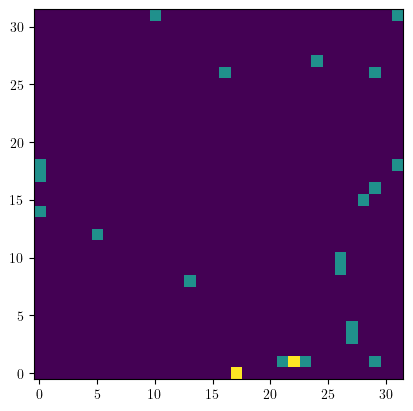

In [92]:
# DM_val.shape
pl.figure()
pl.imshow(DM_val[0,0,16,...].detach().cpu().to(torch.float16).numpy(), origin='lower')




In [93]:
# DM_val.shape
# batch_size
DM_val_tosplit = DM_val.detach().cpu().to(torch.float16).numpy()[:batch_size, 0, ...].reshape(batch_size, DM_val.shape[-1]**3)
DM_val_tosplit_mean = np.mean(DM_val_tosplit, axis=-1)


In [94]:





# pl.figure()
# _ = pl.hist(DM_val_tosplit_mean)



In [95]:

vlow = 0.00075
vmid = 0.0013

indlow = np.where(DM_val_tosplit_mean < vlow)[0]
indmid = np.where((DM_val_tosplit_mean >= vlow) & (DM_val_tosplit_mean < vmid))[0]
indhigh = np.where(DM_val_tosplit_mean >= vmid)[0]

print(len(indlow), len(indmid), len(indhigh))



220 653 151


In [96]:
from tqdm import tqdm
idx_inp = torch.zeros((1, 1), dtype=torch.long, device=device)
nvox_samp = 1024
max_new_tokens = 160
idx_all = []
for jv in tqdm(range(nvox_samp)):
    idx = idx_inp
    for _ in range(max_new_tokens):
        # crop idx to the last block_size tokens
        idx_cond = idx[:, -block_size:]
        # get the predictions
        logits, loss = model(idx_cond, DM_val[jv,...].unsqueeze(0))
        # focus only on the last time step
        logits = logits[:, -1, :] # becomes (B, C)
        # apply softmax to get probabilities
        probs = F.softmax(logits, dim=-1) # (B, C)
        # sample from the distribution
        idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
        # append sampled index to the running sequence
        if idx_next == end_token:
            break
        idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
    idx_all.append(idx)
    

  0%|          | 0/1024 [00:00<?, ?it/s]

100%|██████████| 1024/1024 [04:45<00:00,  3.59it/s]


In [97]:
# idx_all[0:3]
# DM_val[jv,...].unsqueeze(0).shape
jv = 0
idx_inp = torch.zeros((1, 1), dtype=torch.long, device=device)
idx = idx_inp
idx_cond = idx[:, -block_size:]
idx_cond.shape


torch.Size([1, 1])

In [98]:
# idx_all



In [99]:
Mmin_cut = 1e13
lgMin = np.log10(Mmin_cut)
lgMax = 15.5


In [100]:
Nhalo_all_truth = []
Mhalo_all_truth = []

for jv in range(nvox_samp):
    idx = X_val[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all_truth.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                Mhalo_all_truth.append(Mhalo)
            except:
                Mhalo_all_truth.append(np.array([]))
                pass
        else:
            Mhalo_all_truth.append(np.array([]))

    else:
        Nhalo_all_truth.append(np.array([]))
        Mhalo_all_truth.append(np.array([]))



/tmp/ipykernel_3399291/146409788.py:26: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_3399291/146409788.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin


In [101]:
# idx_all
Nhalo_all = []
Mhalo_all = []

for jv in range(nvox_samp):
    idx = idx_all[jv]
    idx = idx.cpu().numpy().flatten()
    # idx = idx[1:]
    # idx = idx[:np.where(idx == end_token)[0][0]]
    # idx = idx.reshape(-1, 5)
    idxe = np.where(idx == space_token)[0] + 1
    idx0 = np.where(idx == start_token)[0] + 1
    # check with idx0 is a scalar or an array:
    # try:
        # temp = len(idx0)
        # print(temp)
    # except:
    if len(idx0) == 1:
        Nhalo = len(idxe) + len(idx0)
        Nhalo_all.append(Nhalo)
    
        if Nhalo > 0:
            try:
                Mhalo = np.zeros(Nhalo)
                for jh in range(Nhalo):
                    if jh == 0:
                        Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
                    else:
                        if Nhalo > 2:
                            Mhalo[jh] = bins_digitize[idx[idxe[jh-1]]] * (lgMax - lgMin) + lgMin
                        else:
                            Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin
                Mhalo_all.append(Mhalo)
            except:
                Mhalo_all.append(np.array([]))
                pass
        else:
            Mhalo_all.append(np.array([]))

    else:
        Nhalo_all.append(np.array([]))
        Mhalo_all.append(np.array([]))


/tmp/ipykernel_3399291/3013671404.py:27: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idx0]] * (lgMax - lgMin) + lgMin
/tmp/ipykernel_3399291/3013671404.py:32: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Mhalo[jh] = bins_digitize[idx[idxe]] * (lgMax - lgMin) + lgMin


In [102]:
len(Nhalo_all)


1024

In [103]:
# idxe
# idxe[jh-1]
# idx[idxe[jh-1]]
# idx
# Mhalo_all
# sum(Mhalo_all, [])
Mhalo_all_concat_low = []
Mhalo_all_concat_mid = []
Mhalo_all_concat_high = []
for jv in indlow:
    Mhalo_all_concat_low.extend(Mhalo_all[jv])

for jv in indmid:
    Mhalo_all_concat_mid.extend(Mhalo_all[jv])

for jv in indhigh:
    Mhalo_all_concat_high.extend(Mhalo_all[jv])
        


In [104]:
# Mhalo_all_truth_concat = []
# for jv in range(len(Mhalo_all_truth)):
    # Mhalo_all_truth_concat.extend(Mhalo_all_truth[jv])

Mhalo_all_truth_concat_low = []
Mhalo_all_truth_concat_mid = []
Mhalo_all_truth_concat_high = []

for jv in indlow:
    Mhalo_all_truth_concat_low.extend(Mhalo_all_truth[jv])

for jv in indmid:
    Mhalo_all_truth_concat_mid.extend(Mhalo_all_truth[jv])

for jv in indhigh:
    Mhalo_all_truth_concat_high.extend(Mhalo_all_truth[jv])

    


In [105]:
len(Mhalo_all_truth_concat_low), len(Mhalo_all_truth_concat_mid), len(Mhalo_all_truth_concat_high)


(658, 6380, 3307)

In [106]:
len(Mhalo_all_concat_low), len(Mhalo_all_concat_mid), len(Mhalo_all_concat_high)


(753, 5907, 2658)

In [107]:
# # Nhalo_all
# # Nhalos_truth
# pl.figure()
# _ = pl.hist(Nhalo_all, bins=18, range=(0,32), density=True, histtype='step', label='mock')
# # _ = pl.hist(Nhalos_truth.flatten(), bins=18, range=(0,32), density=True, histtype='step', label='truth')
# _ = pl.hist(Nhalo_all_truth, bins=18, range=(0,32), density=True, histtype='step', label='truth')
# pl.yscale('log')
# pl.legend(fontsize=15)
# pl.xlabel('Number of halos', fontsize=15)
# pl.ylabel('PDF', fontsize=15)



In [108]:
# lgMsim_truth = dfhalo_ngp_wxyzM[:,:,:,:,3].flatten()
# # select non-zero masses:
# indpos = np.where(lgMsim_truth != 0.0)[0]
# lgMsim_truth = lgMsim_truth[indpos]


Text(0.5, 1.0, 'High density voxels, $\\bar{\\delta}_{{\\rm 32Mpc}/h} > 1.3$')

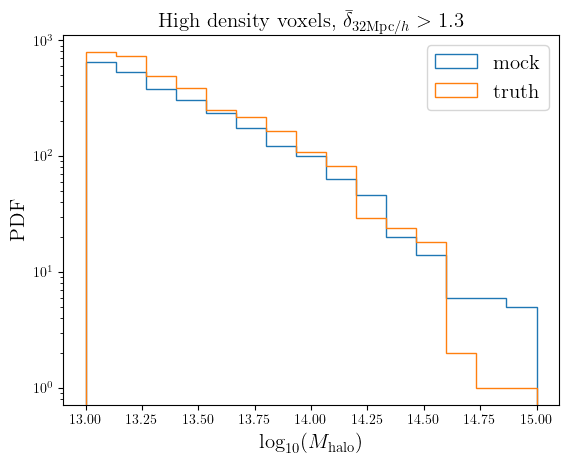

In [120]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_high, bins=15, range=(lgMin, 15),  histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_high, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'High density voxels, $\bar{\delta}_{{\rm 32Mpc}/h} > 1.3$', size=15)


Text(0.5, 1.0, 'Mid density voxels, $0.75 < \\bar{\\delta}_{{\\rm 32Mpc}/h} < 1.3$')

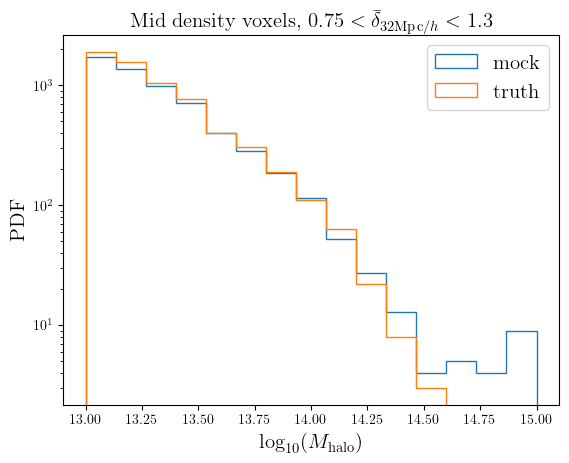

In [121]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_mid, bins=15, range=(lgMin, 15), histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_mid, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'Mid density voxels, $0.75 < \bar{\delta}_{{\rm 32Mpc}/h} < 1.3$', size=15)


Text(0.5, 1.0, 'Low density voxels, $\\bar{\\delta}_{{\\rm 32Mpc}/h} < 0.75$')

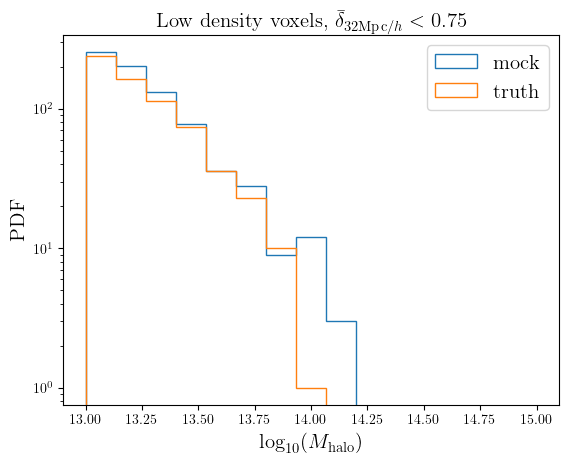

In [122]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_low, bins=15, range=(lgMin, 15), histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat_low, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)
pl.title(r'Low density voxels, $\bar{\delta}_{{\rm 32Mpc}/h} < 0.75$', size=15)


Text(0, 0.5, 'PDF')

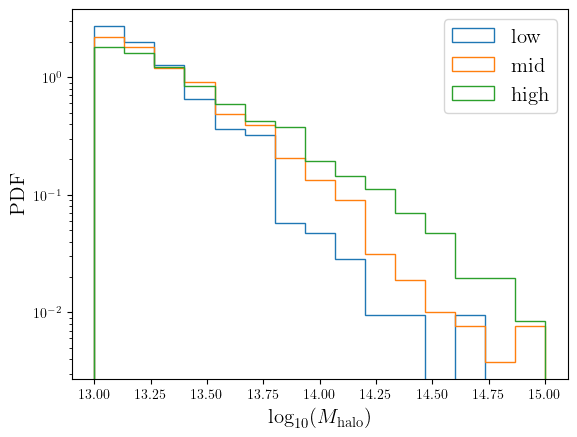

In [48]:
pl.figure()
_ = pl.hist(Mhalo_all_concat_low, bins=15, range=(lgMin, 15), density=True, histtype='step', label='low')
_ = pl.hist(Mhalo_all_concat_mid, bins=15, range=(lgMin, 15), density=True, histtype='step', label='mid')
_ = pl.hist(Mhalo_all_concat_high, bins=15, range=(lgMin, 15), density=True, histtype='step', label='high')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
# _ = pl.hist(Mhalo_all_truth_concat_low, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)



Text(0, 0.5, 'PDF')

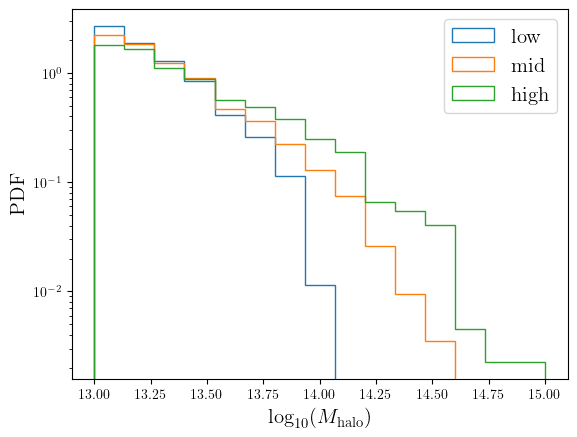

In [49]:
pl.figure()
_ = pl.hist(Mhalo_all_truth_concat_low, bins=15, range=(lgMin, 15), density=True, histtype='step', label='low')
_ = pl.hist(Mhalo_all_truth_concat_mid, bins=15, range=(lgMin, 15), density=True, histtype='step', label='mid')
_ = pl.hist(Mhalo_all_truth_concat_high, bins=15, range=(lgMin, 15), density=True, histtype='step', label='high')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
# _ = pl.hist(Mhalo_all_truth_concat_low, bins=15, range=(lgMin, 15), histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)




Text(0, 0.5, 'PDF')

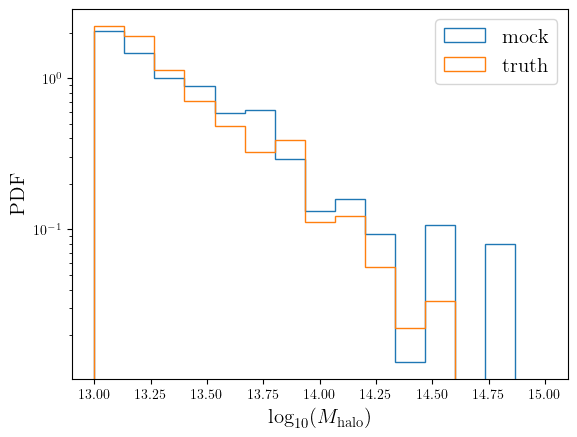

In [59]:
# Nhalo_all
pl.figure()
_ = pl.hist(Mhalo_all_concat, bins=15, range=(lgMin, 15), density=True, histtype='step', label='mock')
# _ = pl.hist(lgMsim_truth, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
_ = pl.hist(Mhalo_all_truth_concat, bins=15, range=(lgMin, 15), density=True, histtype='step', label='truth')
pl.yscale('log')
pl.legend(fontsize=15)
pl.xlabel(r'$\log_{10}(M_{\rm halo})$', size=15)
pl.ylabel(r'PDF', size=15)




In [154]:

# # generate from the model
# context = torch.zeros((1, 1), dtype=torch.long, device=device)
# # print(decode(m.generate(context, max_new_tokens=2000)[0].tolist()))
# m.generate(context, max_new_tokens=160, nvox_samp=32)

source_batch = torch.LongTensor([
    [1, 2, 3, 0, 0, 0],
    [1, 2, 3, 4, 5, 6],
    [1, 2, 3, 4, 5, 0]
])

mask_batch = (source_batch != 0)



In [157]:
# mask_batch.unsqueeze(-1).shape


torch.Size([3, 6, 1])

In [182]:
# mask_batch.shape




In [190]:
# mask_batch_final.shape
# mask_batch_final[0,:,:] * float('-inf')
# put -inf values at mask==True positions:


In [192]:
# masked_logits
# mask_batch_final
# mask_batch_final = mask_batch_final.masked_fill(mask_batch_final == True, float('-inf'))


tensor([[[False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]],

        [[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],

        [[False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [ True,  True,  True,  True,  True,  True]]])

In [181]:
# mask_batch_final


tensor([[[False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [False, False, False,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True],
         [ True,  True,  True,  True,  True,  True]],

        [[False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False],
         [False, False, False, False, False, False]],

        [[False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [False, False, False, False, False,  True],
         [ True,  True,  True,  True,  True,  True]]])

In [ ]:
nMax_part = 150
dfpart_ngp_wxyzM = np.float32(np.zeros((grid, grid, grid, nMax_part, 4)))
# dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
# dfhalo_ngp_wy = np.float32(np.zeros((grid, grid, grid, nMax_h)))
# dfhalo_ngp_wz = np.float32(np.zeros((grid, grid, grid, nMax_h)))
# NGP_xyz(np.float32(pos_h_truth), dfhalo_ngp_wxyz_remainder, dfhalo_ngp_wxyz_factor, BoxSize)

NGP_xyzM(np.float32(pos_m_truth), np.float32(np.zeros(len(pos_m_truth))), dfpart_ngp_wxyzM, BoxSize)

dfpart_ngp_wxyz = dfpart_ngp_wxyzM[...,:3]


(0.0, 5.0)

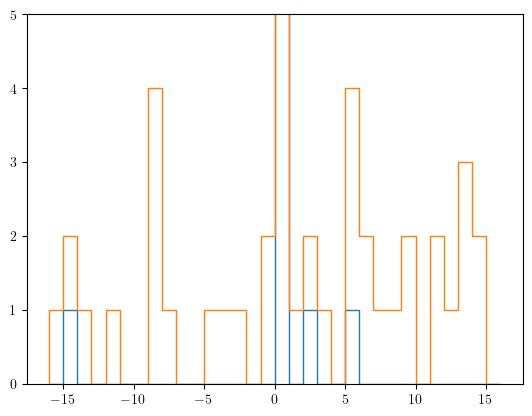

In [29]:
# dfhalo_ngp_wxyzM.shape, dfpart_ngp_wxyzM.shape
pl.figure()
_ = pl.hist(dfhalo_ngp_wxyzM[0,0,3,:,0].flatten(), bins=32, range=(-16, 16), histtype='step')
_ = pl.hist(dfpart_ngp_wxyz[0,0,3,:,0].flatten(), bins=32, range=(-16, 16), histtype='step')
# pl.scatter(dfhalo_ngp_wxyzM[0,0,0,:,0], dfpart_ngp_wxyz[0,0,0,:,0])
pl.ylim(0,5)


In [30]:
# np.amin(dfpart_ngp_wxyz), np.amax(dfpart_ngp_wxyz)
# dfhalo_ngp_wxyz.shape
lb_size = 15.625


(-15.625, 15.624875)

In [18]:
dfhalo_ngp_wmass = np.float32(np.zeros((grid, grid, grid, nMax_h)))
NGP_mass(np.float32(pos_h_truth), np.float32(lgMass_truth), dfhalo_ngp_wmass, BoxSize)

# M_halos = np.flip(np.sort(dfhalo_ngp_wmass, axis=-1), axis=-1)


In [19]:
Nhalos = np.float32(np.zeros((grid, grid, grid)))
MASL.NGP(np.float32(pos_h_truth), Nhalos, BoxSize)


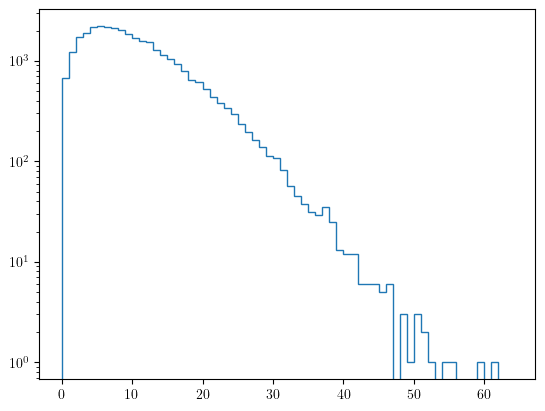

In [21]:
# np.amax(Nhalos)
pl.figure()
_ = pl.hist(Nhalos.flatten(), bins=64, range=(0, 64), histtype='step')
pl.yscale('log')



In [22]:
# np.argsort(dfhalo_ngp_wmass, axis=-1)
M_halos_argsort = np.flip(np.argsort(dfhalo_ngp_wmass, axis=-1), axis=-1)

# M_halos_argsort
# M_halos_argsort.shape, dfhalo_ngp_wxyz.shape
# dfhalo_ngp_xyz_sorted = dfhalo_ngp_wxyz[M_halos_argsort]
dfhalo_ngp_xyz_sorted = np.zeros_like(dfhalo_ngp_wxyz)
for i1 in range(grid):
    for i2 in range(grid):
        for i3 in range(grid):
            # for i4 in range(nMax_h):
            dfhalo_ngp_xyz_sorted[i1, i2, i3, :, 0] = dfhalo_ngp_wxyz[i1, i2, i3, M_halos_argsort[i1, i2, i3], 0]
            dfhalo_ngp_xyz_sorted[i1, i2, i3, :, 1] = dfhalo_ngp_wxyz[i1, i2, i3, M_halos_argsort[i1, i2, i3], 1]
            dfhalo_ngp_xyz_sorted[i1, i2, i3, :, 2] = dfhalo_ngp_wxyz[i1, i2, i3, M_halos_argsort[i1, i2, i3], 2]                        




In [326]:
# M_halos_argsort
pl.figure()



In [328]:
# # Nhalos_truth_recomb.shape
# indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo = np.unravel_index(np.argmax(Nhalos_truth_recomb, axis=None), Nhalos_truth_recomb.shape)

# # ind_max_Nhalo
# # indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo
# Nhalos_truth_recomb[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo]
# # dfhalo_ngp_wxyz_remainder[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,:, 1]
# dfhalo_ngp_xyz_sorted[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,:, 1]


In [329]:
root = '/mnt/home/fvillaescusa/ceph/Quijote/Snapshots/fiducial_HR'
# # if snapnum > 0:
ptypes       = [1]
snapshot = '%s/%d/snapdir_%03d/snap_%03d'%(root,isim_fid,snapnum,snapnum)
# df_ngp = MASL.density_field_gadget(snapshot, ptypes, 128, MAS='NGP',
#                                 do_RSD=False, axis=0, verbose=False)
# # df_ngp = MASL.density_field_gadget(snapshot, ptypes, 128, MAS='CIC',
# #                                 do_RSD=False, axis=0, verbose=False)
# # df_pylians_ngp_128 = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
# df_pylians_ngp_128 = df_ngp/np.mean(df_ngp, dtype=np.float64)



In [330]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], Nhalos.flatten()[::10], s=0.1)
# pl.scatter( Nhalos.flatten()[::10], df_pylians_ngp_128.flatten()[::10], s=0.1)
# pl.ylim(0, 20)

In [331]:
df_ngp = MASL.density_field_gadget(snapshot, ptypes, 512, MAS='NGP',
                                do_RSD=False, axis=0, verbose=False)
# df_ngp = MASL.density_field_gadget(snapshot, ptypes, 512, MAS='CIC',
                                # do_RSD=False, axis=0, verbose=False)
# df_pylians_ngp_512 = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
df_pylians_ngp_512 = df_ngp/np.mean(df_ngp, dtype=np.float64)     



In [332]:
# df_ngp = MASL.density_field_gadget(snapshot, ptypes, 1024, MAS='NGP',
#                                 do_RSD=False, axis=0, verbose=False)
# # df_ngp = MASL.density_field_gadget(snapshot, ptypes, 512, MAS='CIC',
#                                 # do_RSD=False, axis=0, verbose=False)
# # df_pylians_ngp_512 = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
# df_pylians_ngp_1024 = df_ngp/np.mean(df_ngp, dtype=np.float64)     



In [333]:
# df_ngp = MASL.density_field_gadget(snapshot, ptypes, 256, MAS='NGP',
#                                 do_RSD=False, axis=0, verbose=False)
# # df_ngp = MASL.density_field_gadget(snapshot, ptypes, 512, MAS='CIC',
#                                 # do_RSD=False, axis=0, verbose=False)
# # df_pylians_ngp_512 = df_ngp/np.mean(df_ngp, dtype=np.float64)-1.0            
# df_pylians_ngp_256 = df_ngp/np.mean(df_ngp, dtype=np.float64)     



In [334]:
# df_pylians_ngp_512_rs2 = np.reshape(df_pylians_ngp_512, (128,128,128,4,4,4))
# df_pylians_ngp_256_rs3 = np.reshape(df_pylians_ngp_256, (128,2,128,2,128,2))


In [335]:
df_pylians_ngp_512_rs3 = np.reshape(df_pylians_ngp_512, (128,4,128,4,128,4))


In [336]:
# df_pylians_ngp_1024_rs3 = np.reshape(df_pylians_ngp_1024, (128,8,128,8,128,8))



In [337]:
# # df_pylians_ngp_512_rs = np.reshape(df_pylians_ngp_512, (128,128,128,4,4,4))
# df_pylians_ngp_512_rs = np.zeros((128,128,128,4,4,4))

# for j1 in range(128):
#     for j2 in range(128):
#         for j3 in range(128):
#             df_pylians_ngp_512_rs[j1, j2, j3] = np.reshape(df_pylians_ngp_512[j1*4:(j1+1)*4, j2*4:(j2+1)*4, j3*4:(j3+1)*4], (4,4,4))


In [338]:
# df_pylians_ngp_512[j1*4:(j1+1)*4, j2*4:(j2+1)*4, j3*4:(j3+1)*4].shape


In [339]:
# df_pylians_ngp_512_rs_128 = np.mean(df_pylians_ngp_512_rs, axis=(3,4,5))



In [340]:
# df_pylians_ngp_512_rs2_128 = np.mean(df_pylians_ngp_512_rs2, axis=(3,4,5))



In [341]:
# df_pylians_ngp_256_rs3_128 = df_pylians_ngp_256_rs3.mean(5).mean(3).mean(1)



In [342]:
# df_pylians_ngp_512_rs3_128 = df_pylians_ngp_512_rs3.mean(5).mean(3).mean(1)


In [343]:
# df_pylians_ngp_1024_rs3_128 = df_pylians_ngp_1024_rs3.mean(5).mean(3).mean(1)



In [344]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_512_rs_128.flatten()[::10], Nhalos.flatten()[::10], s=0.1)
# # pl.scatter(Nhalos.flatten()[::10], df_pylians_ngp_512_rs3_128.flatten()[::10], s=0.1)
# pl.scatter(Nhalos.flatten()[::10], df_pylians_ngp_256_rs3_128.flatten()[::10], s=0.1)
# pl.ylim(0, 20)




In [345]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_512_rs_128.flatten()[::10], Nhalos.flatten()[::10], s=0.1)
# pl.scatter(Nhalos.flatten()[::10], df_pylians_ngp_1024_rs3_128.flatten()[::10], s=0.1)
# pl.ylim(0, 20)




In [346]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs_128.flatten()[::10], s=0.1)
# pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_256_rs3_128.flatten()[::10], s=0.1)
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs2_128.flatten()[::10], s=0.1)


In [347]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs_128.flatten()[::10], s=0.1)
# pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs3_128.flatten()[::10], s=0.1)
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs2_128.flatten()[::10], s=0.1)


In [348]:
# pl.figure()
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs_128.flatten()[::10], s=0.1)
# pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_1024_rs3_128.flatten()[::10], s=0.1)
# # pl.scatter(df_pylians_ngp_1024_rs3_128.flatten()[::10], df_pylians_ngp_512_rs3_128.flatten()[::10], s=0.1)
# # pl.scatter(df_pylians_ngp_128.flatten()[::10], df_pylians_ngp_512_rs2_128.flatten()[::10], s=0.1)


In [349]:
# np.corrcoef(df_pylians_ngp_128.flatten(), df_pylians_ngp_256_rs3_128.flatten())
# np.corrcoef(df_pylians_ngp_128.flatten(), df_pylians_ngp_512_rs3_128.flatten())

# np.corrcoef(df_pylians_ngp_128.flatten(), df_pylians_ngp_1024_rs3_128.flatten())


In [350]:
# # dfhalo_ngp_wx.shape
# x_v, y_v, z_v = np.where(Nhalos==5)
# ind_v = 3
# print(Nhalos[x_v[ind_v], y_v[ind_v], z_v[ind_v]])

# dfhalo_ngp_xyz_sorted[x_v[ind_v], y_v[ind_v], z_v[ind_v], :,0]




In [351]:
# dfhalo_ngp_xyz_sorted[x_v[ind_v], y_v[ind_v], z_v[ind_v],:, 0]


In [352]:
# dfhalo_ngp_xyz_sorted.shape

In [353]:
# pl.figure()
# pl.scatter(dfhalo_ngp_xyz_sorted[x_v[ind_v], y_v[ind_v], z_v[ind_v],:, 0], dfhalo_ngp_xyz_sorted[x_v[ind_v], y_v[ind_v], z_v[ind_v],:, 1])
# pl.xlim(-4,4)
# pl.ylim(-4,4)


In [354]:
# pl.figure()
# # pl.imshow(np.sum(df_pylians_ngp_512_rs[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,...], axis=-1), origin='lower')
# # pl.imshow(np.sum(df_pylians_ngp_512_rs[x_v[ind_v], y_v[ind_v], z_v[ind_v],...], axis=-1), origin='lower')
# pl.imshow(np.sum(df_pylians_ngp_512_rs3[x_v[ind_v],:, y_v[ind_v],:, z_v[ind_v],:], axis=-1), origin='lower')



In [355]:
# dfhalo_ngp_wxyz_factor[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,:, 2]


In [356]:
# dfhalo_ngp_wy[indx_max_Nhalo, indy_max_Nhalo, indz_max_Nhalo,:]

dfhalo_ngp_xyz_sorted.shape


(128, 128, 128, 6, 3)

In [357]:
# 2.3%0.2
# saved = {'Nhalos_samp':Nhalos,
#          'Mhalos_samp':M_halos,
#          'Nhalos_truth':Nhalos_truth_recomb,
#          'Mhalos_truth':M_halos_truth_recomb,
#          'features_CNN':features_CNN_all}
# import pickle as pk
# savename = '/mnt/home/spandey/ceph/AR_NPE/notebooks/CMASS_TEST/data_for_GNN_LH3.pk'
# pk.dump(saved, open(savename, 'wb'))
saved = {'xyz_halos_truth_sub_box':dfhalo_ngp_xyz_sorted,
        'hres_rho_dm':df_pylians_ngp_512_rs3.reshape(grid,grid,grid,64),
        # 'Nhalos_samp':Nhalos,
        #  'Mhalos_samp':M_halos,
         'Nhalos_truth':Nhalos_truth_recomb,
         'Mhalos_truth':M_halos_truth_recomb,
         'features_CNN':features_CNN_all}
        
# 'xyz_halos_truth_sub_box':dfhalo_ngp_wxyz_remainder,
        #  'Nhalos_truth':Nhalos_truth_recomb,
        #  'Mhalos_truth':M_halos_truth_recomb,
        #  'features_CNN':features_CNN_all}
import pickle as pk
savename = f'/mnt/home/spandey/ceph/AR_NPE/notebooks/CMASS_TEST/test_xyz/data_for_MDN_fidHR_{isim_fid}.pk'
pk.dump(saved, open(savename, 'wb'))


In [228]:
dfhalo_ngp_wxyz_remainder.shape



(128, 128, 128, 8, 3)

In [114]:
M_halos_truth_recomb.shape



(128, 128, 128, 8)

In [30]:
import numpy as np

ntry = 100000
nsamp = 100
mu_try, sig_try = np.zeros(ntry), np.zeros(ntry)
var_try = np.zeros(ntry)
for ji in range(ntry):
    s1 = np.random.randn(nsamp)
    mu_try[ji], sig_try[ji] = np.mean(s1), np.std(s1)
    var_try[ji] = np.var(s1)



In [15]:
# np.mean(s1), np.std(s1)
import matplotlib
%matplotlib inline
import matplotlib.pyplot as pl


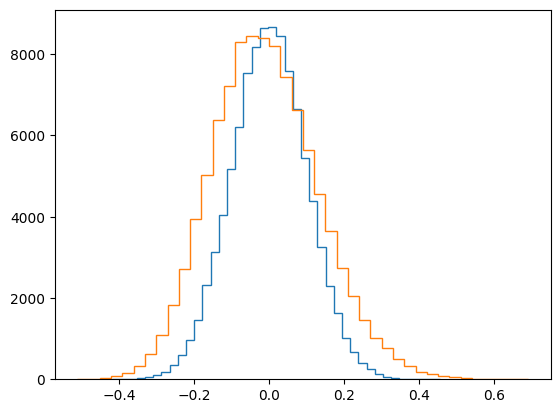

In [31]:
pl.figure()
_ = pl.hist(mu_try, bins=40, histtype='step')
_ = pl.hist(var_try-1., bins=40, histtype='step')
# _ = pl.hist(sig_try-1, bins=40, histtype='step')

In [32]:
np.mean(mu_try), np.std(mu_try)


(-0.0003129160749577889, 0.09996861854525756)

In [29]:
np.mean(sig_try), np.std(sig_try)



(0.9924234829102101, 0.07075275052368166)

In [33]:
np.mean(var_try), np.std(var_try)



(0.9902667524601717, 0.1410539189370056)